## Part 1 : Audio classification

## 0. Initialization

In [1]:
import os
import torch
import librosa
import numpy as np
import pandas as pd
from utils import *
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from model.classifier import Classifier
from dataset.AudioDataset import AudioDataset
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification, HubertForSequenceClassification

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
DATA_DIR = './data/'
RECORDINGS_DIR = DATA_DIR + 'recordings/'
RESULTS_DIR = './results/'
WAVEFORMS_DIR = DATA_DIR + 'waveforms/'

In [4]:
record_df = pd.read_csv(DATA_DIR + 'overview-of-recordings-label.csv')

## 1. Waveforms

> The goal in this section is to convert audio files into waveforms and subsequently train a classifier to predict the label for each audio sample.

#### 1.1 Create waveforms

In [5]:
# Create the waveforms for the train, validate and test sets if they don't exist

if not os.path.exists(WAVEFORMS_DIR):
    # Create the output directory if it doesn't exist
    os.makedirs(WAVEFORMS_DIR)
    for split in ['train', 'validate', 'test']:
        os.makedirs(WAVEFORMS_DIR + split)

    for idx, row in tqdm(record_df.iterrows(), total=len(record_df)):
        # Save the waveforms in a folder structure that is similar to the original data
        save_path = os.path.join(WAVEFORMS_DIR, row.split, row.file_name.replace(".wav", ".pt"))
        audio = os.path.join(RECORDINGS_DIR, row.split, row.file_name)
        # Load the audio file
        waveform, sr = librosa.load(audio, sr=16000)
        
        audio_waveform_with_label = torch.cat((torch.tensor(waveform), torch.tensor([row.label])))

        # Save the audio waveform
        torch.save(audio_waveform_with_label, save_path)

else:
    print("Waveforms already exist")

Waveforms already exist


Exemple

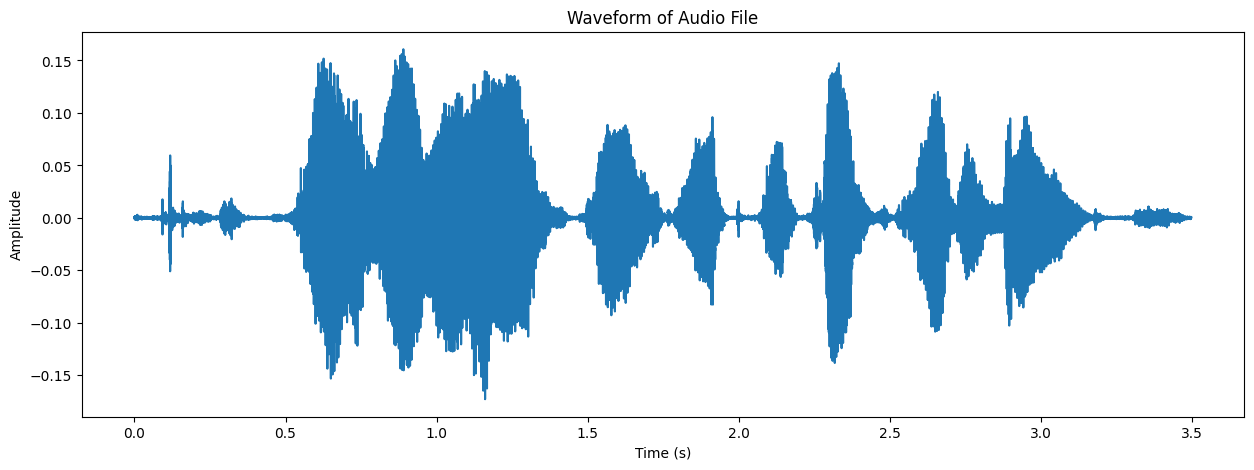

In [6]:
audio_file = 'data/recordings/test/1249120_44142156_61923550.wav'
waveform, sr = librosa.load(audio_file, sr=16000)

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(waveform) / sr, num=len(waveform)), waveform)
plt.title('Waveform of Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### 1.2 Load waveforms

In [ ]:
max_seq_length = 295730

train_waveforms, train_labels = load_waveforms(os.path.join(WAVEFORMS_DIR, "train"), max_seq_length)
valid_waveforms, valid_labels = load_waveforms(os.path.join(WAVEFORMS_DIR, "validate"), max_seq_length)
test_waveforms, test_labels = load_waveforms(os.path.join(WAVEFORMS_DIR, "test"), max_seq_length)
print("Train embeddings shape: ", train_waveforms.shape, "Train labels shape: ", train_labels.shape)
print("Valid embeddings shape: ", valid_waveforms.shape, "Valid labels shape: ", valid_labels.shape)
print("Test embeddings shape: ", test_waveforms.shape, "Test labels shape: ", test_labels.shape)

#### 1.3 Initialize classifier and learning

In [ ]:
NUM_EPOCH = 1000
lr = 1e-4

# Create the classifier
classifier = Classifier(train_waveforms.shape[1], len(record_df.prompt.unique())).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr)

#### 1.4 Train classifier

In [ ]:
train_losses, valid_losses, valid_accs = train_classifier(classifier, criterion, optimizer, NUM_EPOCH, train_waveforms, train_labels, valid_waveforms, valid_labels, device)

#### 1.5 Test classifier

In [ ]:
test_acc, cm = test_classifier(classifier, test_waveforms, test_labels, device)

#### 1.6 Save results

In [ ]:
# Save the model
torch.save(classifier.state_dict(), RESULTS_DIR + "waveforms.pt")

# Save the losses and accuracies as numpy arrays
if not os.path.exists(RESULTS_DIR + "waveforms"):
    os.makedirs(RESULTS_DIR + "waveforms")

np.save(RESULTS_DIR + "waveforms/tr_losses.npy", np.array(train_losses))
np.save(RESULTS_DIR + "waveforms/val_accs.npy", np.array(valid_accs))
np.save(RESULTS_DIR + "waveforms/val_losses.npy", np.array(valid_losses))
np.save(RESULTS_DIR + "waveforms/test_acc.npy", np.array(test_acc))
np.save(RESULTS_DIR + "waveforms/cm.npy", np.array(cm))

> We also attempted to utilize waveform images and train a CNN for audio file classification; however, unfortunately as before, it did not yield successful results.

## 2. Wav2Vec

> The objective in this section is to leverage pre-trained Wav2Vec transformers and attempt to predict the correct labels from audio files.

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-ks")
model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-ks", num_labels=len(record_df.prompt.unique()), ignore_mismatched_sizes=True).to(device)

#### 2.1 Load dataset

In [ ]:
max_seq_length = 295730
batch_size = 5

train_df = record_df[record_df.split == 'train']
valid_df = record_df[record_df.split == 'validate']
test_df = record_df[record_df.split == 'test']

train_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "train", f) for f in train_df["file_name"]], train_df.label.values, feature_extractor, max_seq_length, device)
valid_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "validate", f) for f in valid_df["file_name"]], valid_df.label.values, feature_extractor, max_seq_length, device)
test_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "test", f) for f in test_df["file_name"]], test_df.label.values, feature_extractor, max_seq_length, device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### 2.2 Initialize learning

In [ ]:
NUM_EPOCH = 15
lr = 1e-5

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

#### 2.3 Train model

In [ ]:
train_losses, valid_losses, valid_accs = train_transformer(model, optimizer, NUM_EPOCH, train_loader, valid_loader, device)

#### 2.4 Test model

In [ ]:
test_acc, cm = test_transformer(model, test_loader, device)

#### 2.5 Save results

In [ ]:
# Save the model
torch.save(model.state_dict(), RESULTS_DIR + "wav2vec.pt")

if not os.path.exists(RESULTS_DIR + "wav2vec"):
    os.makedirs(RESULTS_DIR + "wav2vec")

# Save the losses and accuracies as numpy arrays
np.save(RESULTS_DIR + "wav2vec/tr_losses.npy", np.array(train_losses))
np.save(RESULTS_DIR + "wav2vec/val_accs.npy", np.array(valid_accs))
np.save(RESULTS_DIR + "wav2vec/val_losses.npy", np.array(valid_losses))
np.save(RESULTS_DIR + "wav2vec/test_acc.npy", np.array(test_acc))
np.save(RESULTS_DIR + "wav2vec/cm.npy", np.array(cm))

## 3. HuBERT

> The objective in this section is to leverage pre-trained HuBERT transformers and attempt to predict the correct labels from audio files.

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("superb/hubert-base-superb-ks")
model = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-ks", num_labels=len(record_df.prompt.unique()), ignore_mismatched_sizes=True).to(device)

#### 3.1 Load dataset

In [ ]:
max_seq_length = 295730
batch_size = 5

train_df = record_df[record_df.split == 'train']
valid_df = record_df[record_df.split == 'validate']
test_df = record_df[record_df.split == 'test']

train_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "train", f) for f in train_df.file_name], train_df.label.values, feature_extractor, max_seq_length, device)
valid_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "validate", f) for f in valid_df.file_name], valid_df.label.values, feature_extractor, max_seq_length, device)
test_dataset = AudioDataset([os.path.join(RECORDINGS_DIR, "test", f) for f in test_df.file_name], test_df.label.values, feature_extractor, max_seq_length, device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### 3.2 Initialize learning

In [ ]:
NUM_EPOCH = 15
lr = 1e-5

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

#### 3.3 Train model

In [ ]:
train_losses, valid_losses, valid_accs = train_transformer(model, optimizer, NUM_EPOCH, train_loader, valid_loader, device)

#### 3.4 Test model

In [ ]:
test_acc, cm = test_transformer(model, test_loader, device)

#### 3.5 Save results

In [ ]:
# Save the model
torch.save(model.state_dict(), RESULTS_DIR + "hubert.pt")

if not os.path.exists(RESULTS_DIR + "hubert"):
    os.makedirs(RESULTS_DIR + "hubert")

# Save the losses and accuracies as numpy arrays
np.save(RESULTS_DIR + "hubert/tr_losses.npy", np.array(train_losses))
np.save(RESULTS_DIR + "hubert/val_accs.npy", np.array(valid_accs))
np.save(RESULTS_DIR + "hubert/val_losses.npy", np.array(valid_losses))
np.save(RESULTS_DIR + "hubert/test_acc.npy", np.array(test_acc))
np.save(RESULTS_DIR + "hubert/cm.npy", np.array(cm))